# Final project
_by Anders Pedersen_

[0. Introduction](#0)  
[1. EDA](#1)  
[2. Data Cleaning](#2)  
[3. Aggregate data and mean encoding](#3)  
[4. Time series LAG](#4)  
[5. Feature engineering](#5)  
[6. Data leakage search](#6)  
[7. Data clipping](#7)  
[8. Validation](#8)  
[9. Training](#9)  
[10. Predict](#10)  
[11. Conclusion and metric evaluation](#11)  

<!-- toc -->

# 0. Introduction <a name='0'></a>

This competition contains a time-series dataset consisting of daily sales data, from the Russian software firms - 1C Company hosted on Kaggle Inclass found __[here](https://www.kaggle.com/c/competitive-data-science-final-project)__.
The challenge is to predict total sales for every (shop, item) combination in the next month (item_cnt_month).  

This means that we will at some point need to aggregate our training data on (shop, item) combinations per month.  

The column *'date_block_num'* is a consecutive month number. Jan 2013 is 0, Feb 2013 is 1 etc.
The training set runs from Jan 2013 (date_block_num=0) to Oct 2015 (date_block_num=33) and the challenge is hence to predict the sales for Nov 2015 (date_block_num=34).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn import preprocessing
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
test = pd.read_csv('test.csv')
shop = pd.read_csv('shops.csv')
submission = pd.read_csv('sample_submission.csv')
sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_category = pd.read_csv('item_categories.csv')

### Grid for restructuring
We have to restructure train data to match the test data generation.  
To do this we create a 'master' grid.

In [3]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# 1. EDA <a name='1'></a>

### General characteristics of the training and test sets
The sales dataframe have 2935849 rows and 6 colums.  
The row 'item_cnt_day' is the number we will aggregate and use as our labelled data.

In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [6]:
test.shape

(214200, 3)

In [7]:
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [8]:
submission.head(1)

,ID,item_cnt_month
0,0,0.5


One observation here is that if the test set (representing Nov 2015) was similar to an average month of the sales set it should contain around 2935847/33 = 89000 rows. Instead it contains over 200000 rows.  

It turns out that the test set contains all combinations of 42 unique 'shop_id' values and 5100 unique 'item_id' values which corresponds to 42 * 5100 = 214200 rows.  
  
The sales set contains both more unique 'shop_id' values and unique 'item_id' values.

In [9]:
test.groupby(['shop_id']).count().head(4)

,ID,item_id
shop_id,,
2,5100,5100
3,5100,5100
4,5100,5100
5,5100,5100


In [10]:
print('shop_id count (train/test):',sales['shop_id'].nunique(),'/',test['shop_id'].nunique(),
      '\nitem_id count (train/test):',sales['item_id'].nunique(),'/',test['item_id'].nunique())

shop_id count (train/test): 60 / 42 
item_id count (train/test): 21807 / 5100


It turns out that all test 'shop_id' values are included in the sales set. However:  
**There are 363 (out of 5100) unique 'item_id' values in the test set that are not represented in the sales set.**

In [11]:
print('All shop_id included?',test['shop_id'].isin(sales['shop_id']).all())
print('All item_id included?',test['item_id'].isin(sales['item_id']).all())

All shop_id included? True
All item_id included? False


In [12]:
not_in_sales = []
list = np.sort(sales['item_id'].unique())
for i in test['item_id'].unique():
    if not (i in list):
        not_in_sales.append(i)
print('test item_id values not included in sales set:',len(not_in_sales))

test item_id values not included in sales set: 363


It also turns out that the training set is composed as follows:  
**Only items sold in a particular month are included in the sales set.**

In [13]:
sales.groupby(['date_block_num','shop_id','item_id'])['shop_id','date_block_num','item_id'].count().head(4)

shop_id  date_block_num  item_id
date_block_num shop_id item_id                                  
0              0       32             4               4        4
                       33             3               3        3
                       35             1               1        1
                       43             1               1        1

Creating scatter plots of the sales and test datasets confirms this picture

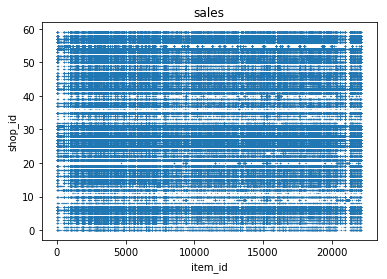

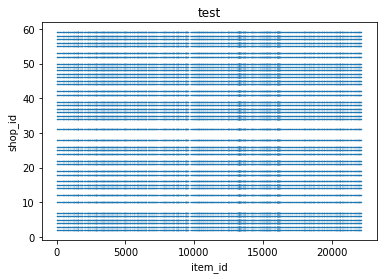

In [14]:
sales.plot.scatter('item_id', 'shop_id', s = 0.01, title='sales')
test.plot.scatter('item_id', 'shop_id', s = 0.01, title='test')

### Time trends
Observing the data there seems to be some proof of peroidic behavior, e.g. it seems the sales are high around new year



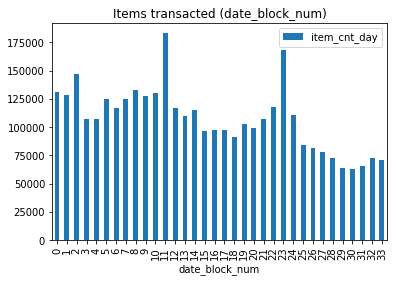

In [15]:
sales.groupby('date_block_num').agg({"item_cnt_day": "sum"}).plot.bar(title="Items transacted (date_block_num)")

This confirms the validity of introducing time-based features.  
Added to the periodicities mentioned above we a also see an overall trend of sales diminishing.

# 2. Data cleaning <a name='2'></a>

Observing the values for 'item_price' and 'item_cnt_day' it looks like we have some erroneous data.  
Hence a bit of cleaning is applied.

In [16]:
for col in ['item_price', 'item_cnt_day']:
    print('column:',col,'- min:',sales[col].min(),'- max:',sales[col].max(),'- mean:',sales[col].mean())

column: item_price - min: -1.0 - max: 307980.0 - mean: 890.8532326979881
column: item_cnt_day - min: -22.0 - max: 2169.0 - mean: 1.242640885140891


In [17]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

Let's check for missing values. It turns out we're fine.

In [18]:
sales.isnull().sum(axis = 0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# 3. Aggregate data and mean encoding <a name='3'></a>

As seen above the test set requires us to predict monthly sales. Hence we need to aggregate the sales data to montly level before proceding

In [19]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

Further join our sales data frame with the item and item category data frames to include more item features

In [20]:
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_category, on=['item_category_id'], how='left')

And then perform mean encoding on all category data which are item_id, shop_id and item_category_id.
In total 9 new features are created:
'item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day

We then perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [21]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

In [22]:
sales_m.head(1)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_category_name,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,310.8,18.0,0.4,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738


# 4. Time series LAG <a name='4'></a>

We will introduce LAG features i.e. use of prior time steps to predict the next time step.

We first append test data into sales data.  
This is needed in order for us to create lag features on them.

In [23]:
temp_copy = test.copy()
temp_copy['date_block_num'] = 34
temp_copy.drop('ID', axis=1, inplace=True)
temp_copy = temp_copy.merge(items, how='left', on='item_id')
temp_copy = temp_copy.merge(item_category, how='left', on='item_category_id')
temp_copy.drop('item_name', axis=1, inplace=True)
sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_copy], axis=0, ignore_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [24]:
lag_variables  = ['item_id_avg_item_price','item_id_sum_item_cnt_day','item_id_avg_item_cnt_day',
'shop_id_avg_item_price','shop_id_sum_item_cnt_day','shop_id_avg_item_cnt_day','item_category_id_avg_item_price',
'item_category_id_sum_item_cnt_day','item_category_id_avg_item_cnt_day','item_cnt_day']

# More lags (longer back in time) might produce better result
# I've limited this in order to fit data frame into memory
lags = [1,2,3]

for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [25]:
sales_m.head(1)

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_name,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,...,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3
0,0,37,0.199738,63.014719,6094.0,Кино - Blu-Ray,1.0,22154,0.4,310.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A little cleanup before proceeding. Let's fill missing values

In [26]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

# 5. Feature engineering <a name='5'></a>

To keep periodicity information in the dataset we'll add a 'month of year' indicator

In [27]:
sales_m['date_block_mod'] = sales_m['date_block_num'] % 12

I have (offline) created the table <categories_en.csv> in two steps:
I took the table <item_categories.csv> and ran it through Google translate
I aggregated the values into super categories e.g. everything containing music is labelled 'Music' etc.
Example: item category name "Игровые консоли - PS2,10" is translated into "Game Consoles - PS2,10". All names containing the words ""Game Consoles" are then mapped to the category "Game Consoles" (stemming).

In [ ]:
#cat_en_df = pd.read_csv('./categories_en.csv')
#sales_m = pd.merge(sales_m, cat_en_df, left_on='item_category_id', right_on='item_category_id')

Similarly I have create the table <shops_en.csv> from the table <shops.csv> through Google translate and then applying stemming.  
Exampe: shop name 'Адыгея ТЦ Мега' is translated to 'Adygea Shopping Center Mega' which is the stemmed to 'Adygea'.

In [ ]:
#shops_en_df = pd.read_csv('./shops_en.csv')
#sales_m = pd.merge(sales_m, shops_en_df, left_on='shop_id', right_on='shop_id')

We need to encoder the new labels as numeric in order for XGBoost to handle then

In [ ]:
#sales_m['cat_en'] = sales_m['cat_en'].astype('category')
#sales_m['shop_en'] = sales_m['shop_en'].astype('category')

In [ ]:
#le = preprocessing.LabelEncoder()
#le = le.fit(sales_m['cat_en'])
#sales_m['cat_en_num'] = le.transform(sales_m['cat_en'])
#le = le.fit(sales_m['shop_en'])
#sales_m['shop_en_num'] = le.transform(sales_m['shop_en'])
#sales_m.head(1)

After test it turns out that adding 'cat_en' and 'shop_en' does not improve the score and they are henced omitted.

# 6. Validation <a name='6'></a>

### Train/test split
As we earlier saw an overall trend of sales diminishing over time
we will focus on the latest data available

In [28]:
sales_m = sales_m[sales_m['date_block_num']>12]

As our dataset is time-based
and our test set is based on data after the train set
we use the last block in the series for validation (hold-out scheme).  
This is an acceptable strategy as we have sufficient data.

Now let's split the combined dataframe.  
Note that X_train includes both features and label column (y_train / item_cnt)

In [29]:
cols_to_drop = lag_variables[:-1] + ['item_price']
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

In [30]:
print('dimensions of X_train:',X_train.shape,'\ndimensions of X_cv:',X_cv.shape)

dimensions of X_train: (5839576, 37) 
dimensions of X_cv: (238172, 37)


### Public/private split
The test set contains 214200 rows.
The public and private test sets are both subsets of this combined test set.  
When we submit we can observe our score towards the public test set.

In [31]:
print('dimensions of test:',test.shape,'\ndimsensions of X_test', X_test.shape)

dimensions of test: (214200, 3) 
dimsensions of X_test (214200, 37)


# 7. Data clipping <a name='7'></a>

Clip the item_cnt_day within 40 (from discussion in Kaggle forum)

In [32]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)
X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)
X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

# 8. Data leakage search <a name='8'></a>

I did not find hidden information in the test set 'ID' column:

In [33]:
test['ID'].head()

0    0
1    1
2    2
3    3
4    4
Name: ID, dtype: int64

There does not seem to be any out-of-date (look into the future) information in the sales set

In [34]:
np.sort(sales['date'].unique())

array(['01.01.2013', '01.01.2014', '01.01.2015', ..., '31.10.2015',
       '31.12.2013', '31.12.2014'], dtype=object)

What about row order in test set?
It seems like there is no hidden information here.  
The values in the columns 'shop_id' and 'item_id' are shuffled and then combined.

In [35]:
for i in range(0,2):
    for j in range(0,2):
        print(test.iloc[[i*5100+j]])

   ID  shop_id  item_id
0   0        5     5037
   ID  shop_id  item_id
1   1        5     5320
        ID  shop_id  item_id
5100  5100        4     5037
        ID  shop_id  item_id
5101  5101        4     5320


So no data leaks found in my search.

# 9. Training <a name='9'></a>

Now let's train a model using XGBoost

In [36]:
params = {
        'eta': 0.08,
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }

In [37]:
cols = [c for c in X_train.columns if c not in ['date_block_num', 'item_cnt_day','item_category_name']]
x1 = X_train[cols]
y1 = X_train['item_cnt_day']
x2 = X_cv[cols]
y2 = X_cv['item_cnt_day']
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 3500,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[11:52:00] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.40522	valid-rmse:1.37906
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.02193	valid-rmse:1.14896
[100]	train-rmse:0.985907	valid-rmse:1.14447
[150]	train-rmse:0.961827	valid-rmse:1.14761
Stopping. Best iteration:
[102]	train-rmse:0.985336	valid-rmse:1.14439



# 10. Predict <a name='10'></a>

Now let's take the model and use it on the test set in order to create a set of predictions.  
Clip the item_cnt_day within 20 (from discussion in Kaggle forum)

In [38]:
pred = model.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model.best_ntree_limit)
test['item_cnt_month'] = pred.clip(0,20)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)

### Save predictions
Let's save the predictions to disc in order to submit them on coursera.org

In [39]:
test.to_csv('submission.csv', index=False)

# 11. Conclusion and metric evaluation <a name='11'></a>

Submitting the prediction above gives
-  public leaderboard score: 0.961135
-  private leaderboard score: 0.969740

This result have an acceptable RMSE loss.  
Also we haven't overfitted towards the public leaderboard (results are not to wide apart).